# Add Biocyc Operon Information

After manual curation, we add operon information from Biocyc. This will aid us later on when we wish to find motifs (MEME via built-in `pymodulon` method) and compare them (TOMTOM via built-in `pymodulon` method).

## Setup

In [1]:
import sys
sys.path.append('..')

from copy import deepcopy
from pymodulon.gene_util import *
from tqdm.notebook import tqdm
import numpy as np
import os
from Bio import SeqIO

---

In [2]:
# Load in curated gene_info file

DF_annot = pd.read_csv('../data/gene_info_curated_Jan_07_2021.tsv', sep='\t', index_col=0)
DF_annot

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq
locus_tag,,,,,,,,,,,,
SACI_RS00005,cdc6-3,Saci_0001,NaN,NaN,101.0,1261.0,+,ORC1-type DNA replication protein 3 (AAA famil...,NaN,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1
SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,NaN,1294.0,1629.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FP71,NC_007181.1
SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,NaN,1665.0,2504.0,+,hypothetical protein,hypothetical protein,Function unknown,A0A0U2NAH6,NC_007181.1
SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,NaN,2553.0,3056.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3HCE5,NC_007181.1
SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,NaN,3049.0,3768.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FGW8,NC_007181.1
...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,NaN,2218618.0,2219355.0,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport,...",A0A0U2NGD2,NC_007181.1
SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,NaN,2219468.0,2220394.0,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1
SACI_RS11475,cobO,Saci_2373,Sacid_02371,NaN,2220381.0,2220989.0,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1


In [3]:
# Load in and process biocyc operon file

DF_biocyc = pd.read_csv('../data/biocyc_smart_table.txt', sep='\t')

# Remove genes with no accession
DF_biocyc = DF_biocyc[DF_biocyc['Accession-1'].notnull()]

# Set the accession (i.e. locus tag) as index
DF_biocyc = DF_biocyc.set_index('Accession-1').sort_values('Left-End-Position')

# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(DF_annot.index)

# Reformat transcription units
DF_biocyc['operon_list'] = DF_biocyc['Accession-1.1'].apply(reformat_biocyc_tu)

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list
locus_tag,,,,,,,
SACI_RS00005,SACI_RS00005,101,1261,AAA family ATPase,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00005;SACI_RS00010;SACI_RS00015
SACI_RS00010,SACI_RS00010,1294,1629,hypothetical protein,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00005;SACI_RS00010;SACI_RS00015
SACI_RS00015,SACI_RS00015,1665,2504,hypothetical protein,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00005;SACI_RS00010;SACI_RS00015
SACI_RS00020,SACI_RS00020,2553,3056,hypothetical protein,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00020;SACI_RS00025;SACI_RS00030
SACI_RS00025,SACI_RS00025,3049,3768,hypothetical protein,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00020;SACI_RS00025;SACI_RS00030


## Assign Unique IDs to operons

In [4]:
# Get all operons
operons = DF_biocyc['operon_list'].unique()

# Map each operon to a unique string
operon_dict = {operon: "Op"+str(i) for i, operon in enumerate(operons)}

# Add names to dataframe
DF_biocyc['operon'] = [operon_dict[op] for op in DF_biocyc["operon_list"]]

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list,operon
locus_tag,,,,,,,,
SACI_RS00005,SACI_RS00005,101,1261,AAA family ATPase,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00005;SACI_RS00010;SACI_RS00015,Op0
SACI_RS00010,SACI_RS00010,1294,1629,hypothetical protein,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00005;SACI_RS00010;SACI_RS00015,Op0
SACI_RS00015,SACI_RS00015,1665,2504,hypothetical protein,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00015 // SACI_RS00010 // SACI_RS00005,SACI_RS00005;SACI_RS00010;SACI_RS00015,Op0
SACI_RS00020,SACI_RS00020,2553,3056,hypothetical protein,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00020;SACI_RS00025;SACI_RS00030,Op1
SACI_RS00025,SACI_RS00025,3049,3768,hypothetical protein,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00030 // SACI_RS00025 // SACI_RS00020,SACI_RS00020;SACI_RS00025;SACI_RS00030,Op1


In [5]:
# Merge Biocyc information with main annotation DF
DF_annot['operon'] = DF_biocyc['operon']

In [6]:
if 'refseq' in DF_annot.columns:
    DF_annot.rename(columns={'refseq': 'accession'}, inplace=True)

In [7]:
# Clean up and save annotation
order = ['gene_name','old_locus_tag','prokka_locus_tag', 'synonyms', 'start','end','strand','gene_product', 'gene_product_prokka', 'COG','uniprot', 'accession', 'operon']    

DF_annot = DF_annot[order]

In [8]:
DF_annot['start'] = DF_annot['start'].astype(int)
DF_annot['end'] = DF_annot['end'].astype(int)

In [9]:
DF_annot

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon
locus_tag,,,,,,,,,,,,,
SACI_RS00005,cdc6-3,Saci_0001,NaN,NaN,101,1261,+,ORC1-type DNA replication protein 3 (AAA famil...,NaN,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1,Op0
SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,NaN,1294,1629,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FP71,NC_007181.1,Op0
SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,NaN,1665,2504,+,hypothetical protein,hypothetical protein,Function unknown,A0A0U2NAH6,NC_007181.1,Op0
SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,NaN,2553,3056,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3HCE5,NC_007181.1,Op1
SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,NaN,3049,3768,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FGW8,NC_007181.1,Op1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,NaN,2218618,2219355,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport,...",A0A0U2NGD2,NC_007181.1,Op1444
SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,NaN,2219468,2220394,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1,Op1445
SACI_RS11475,cobO,Saci_2373,Sacid_02371,NaN,2220381,2220989,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1,Op1446


## Final Statistics

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

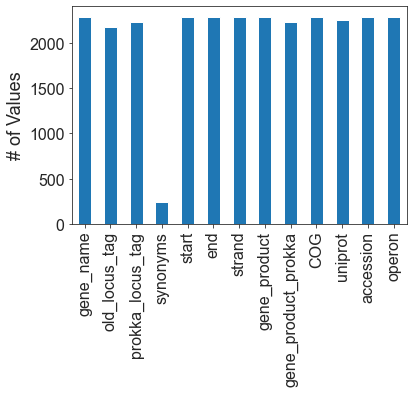

In [11]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

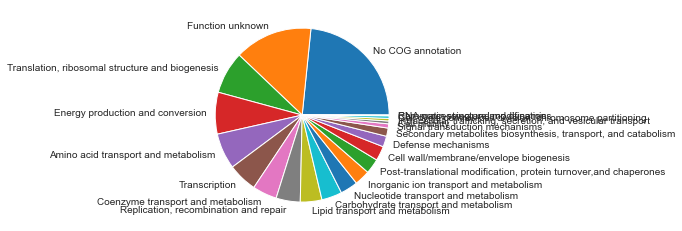

In [12]:
counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

In [13]:
DF_annot.to_csv('../data/gene_info_curated_with_operons.tsv', sep='\t')